Paper : Efficient Infrequent Pattern Mining
Using Negative Itemset Tree
by Yifeng Lu, Florian Richter and Thomas Seid

In [1]:
class colors:
  red ='\033[31m'
  green ='\033[32m'
  orange ='\033[33m'
  blue ='\033[34m'
  yellow ='\033[93m'
  ENDC = "\033[0m"

In [2]:
def print_red(text):
  to_print = f"{colors.red}{text}{colors.ENDC}"
  print(to_print,end="")

# Generates Negative itemset.

In [3]:
def get_negative_itemset(all_items,T):

  neg_item_set = list()
  for item_set in T:
    neg_item_set.append(all_items.difference(item_set))

  return neg_item_set

# Compute frequency of each item in negative itemset.

In [4]:
def gen_frequency_table(all_items,neg_item_set):
  freq_dict = dict.fromkeys(all_items,0) 

  for item_set in neg_item_set:
    for item in item_set:
      freq_dict[item] += 1

  return freq_dict

In [5]:
def get_freq(key):
  return freq_dict[key]

In [6]:
def reorder_nis_based_on_freq(neg_item_set):
  
  neg_item_set_ordered = list()
  for item_set in neg_item_set:
    neg_item_set_ordered.append((sorted(item_set,key=get_freq,reverse=True)))

  return neg_item_set_ordered

In [7]:
# Sample Itemsets and Transaction
all_items = {'a','b','c','d','e'}
T = [ {'a','b','c'}, {'a','b','d'}, {'b','c'}, {'a','b'}, {'a','b','e'},{'d','e'} ]

neg_item_set = get_negative_itemset(all_items,T)
# Negative Itemset of the transaction
neg_item_set

[{'d', 'e'},
 {'c', 'e'},
 {'a', 'd', 'e'},
 {'c', 'd', 'e'},
 {'c', 'd'},
 {'a', 'b', 'c'}]

In [8]:
freq_dict = gen_frequency_table(all_items,neg_item_set)
freq_dict

{'a': 2, 'b': 1, 'c': 4, 'd': 4, 'e': 4}

In [9]:
neg_item_set_ordered = reorder_nis_based_on_freq(neg_item_set)
neg_item_set_ordered

[['e', 'd'],
 ['c', 'e'],
 ['e', 'd', 'a'],
 ['c', 'e', 'd'],
 ['c', 'd'],
 ['c', 'a', 'b']]

In [10]:
def get_len(key):
  return len(key)

neg_item_set_ordered = sorted(neg_item_set_ordered,key=get_len)

neg_item_set_ordered

[['e', 'd'],
 ['c', 'e'],
 ['c', 'd'],
 ['e', 'd', 'a'],
 ['c', 'e', 'd'],
 ['c', 'a', 'b']]

In [11]:
neg_item_set_ordered = [['d','e'],
                         ['c','e'],
                         ['c','d'],
                         ['d','e','a'],
                         ['c','d','e'],
                         ['c','a','b']]

In [12]:
class Node:
  def __init__(self,item,count):
    self.item = item
    self.count = count
    self.children = []
    self.parent = None
    self.is_terminating = False
    self.termination_node = False # Marked with RED in the Paper.

  def get_level(self):
    level = 0
    p = self.parent
    while p:
      level += 1
      p = p.parent

    return level

  def print_tree(self):
    spaces = ' ' * self.get_level() * 4
    prefix = spaces + "|__" if self.parent else ""
    print(prefix,end="")
    print(self.item,end="")
    print("({})".format(self.count))

    if self.children:
      for child in self.children:
        child.print_tree()

  def print_tree_level(self,level):
    if self.get_level() > level:
      return
    spaces = ' ' * self.get_level() * 3
    prefix = spaces + "|__" if self.parent else ""
    print(prefix,end="")
    print(self.item,end="")
    print("({})".format(self.count))
    
    if self.children:
      for child in self.children:
        child.print_tree_level(level)

In [13]:
class Neg_Tree:
  def __init__(self,all_items):
    self.root = Node(all_items,0)

  def add_item(self,Transaction): # {c,d}
    curr_node = self.root
    count = 0
    total_count = 0

    for item in Transaction:
      count = 0
      if any(x for x in curr_node.children if x.item == item) == False:
        if item == Transaction[-1]:
          count = 1
        
        child = Node(item,count)
        child.parent = curr_node
        curr_node.children.append(child)
        
        # Condition for marking terminal node.
        if count == 1 and total_count == 0:
          child.termination_node = True
      
      for node in curr_node.children:
        total_count += node.count
        if item == node.item:
          curr_node = node
          break

In [14]:
N_tree = Neg_Tree(all_items)

In [15]:
# adding items to the tree.
for item in neg_item_set_ordered:
  N_tree.add_item(item)

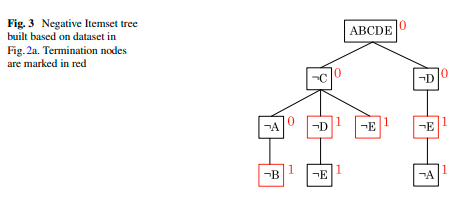

In [16]:
N_tree.root.print_tree()

{'e', 'a', 'b', 'c', 'd'}(0)
    |__d(0)
        |__e(1)
            |__a(1)
    |__c(0)
        |__e(1)
        |__d(1)
            |__e(1)
        |__a(0)
            |__b(1)


In [17]:
N_tree.root.children[0].parent.item

{'a', 'b', 'c', 'd', 'e'}

In [18]:
# Level wise printing
N_tree.root.print_tree_level(2)

{'e', 'a', 'b', 'c', 'd'}(0)
   |__d(0)
      |__e(1)
   |__c(0)
      |__e(1)
      |__d(1)
      |__a(0)


In [19]:
# As per the procedure mentioned in page 7 of the paper section 4.1
def TraverseSubtree(n,p,itemset):
  for n_dash in n.children: 
    if n_dash.item in p.item:
      p.children.append(n_dash)
      n_dash.parent = p

    else:
      p.count += n_dash.count
      TraverseSubtree(n_dash,p,itemset) 


In [20]:
# As per the procedure mentioned in page 7 of the paper section 4.1
def NI_tree_substraction(root,items_remove):
  negation_item_removed = root.item.difference(set(items_remove))
  new_node_item = negation_item_removed 

  new_node = Node(new_node_item,root.count)
  TraverseSubtree(root,new_node,new_node.item)

  return new_node

In [21]:
# Please refer to Fig. 4 of section 4.1. Below we are testing the output of 
# Negative tree substraction.
# Removing c from the tree.
x = {'c'}

In [22]:
r1 = NI_tree_substraction(N_tree.root,x)

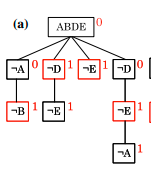

In [23]:
r1.print_tree()

{'a', 'e', 'd', 'b'}(0)
    |__d(0)
        |__e(1)
            |__a(1)
    |__e(1)
    |__d(1)
        |__e(1)
    |__a(0)
        |__b(1)


In [24]:
# Removing d
rx = NI_tree_substraction(r1,'d')

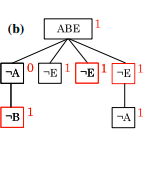

In [25]:
rx.print_tree()

{'a', 'e', 'b'}(1)
    |__e(1)
        |__a(1)
    |__e(1)
    |__e(1)
    |__a(0)
        |__b(1)


In [26]:
rx1 = NI_tree_substraction(rx,'b')

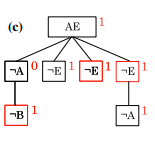

In [27]:
rx1.print_tree()

{'a', 'e'}(1)
    |__e(1)
        |__a(1)
    |__e(1)
    |__e(1)
    |__a(0)
        |__b(1)


In [28]:
freq_dict['$'] = -1
freq_dict

{'$': -1, 'a': 2, 'b': 1, 'c': 4, 'd': 4, 'e': 4}

In [29]:
def Is_less_frequent(ix,i_1):

  print("ix:{} and item:{}".format(ix,i_1))  
  #try:
  if freq_dict[ix] < freq_dict[i_1]:
    print("freq_dict[ix]:{} ,freq_dict[item]:{}".format(freq_dict[ix],freq_dict[i_1]))
      #print('-'*20)
    return True 
  else:
    return False
  #except Exception:
    #print("Key not found: {}".format(ix))
    #return True

In [30]:
def RecursiveRemove_test(noder,minsup,IL,FL,ix):

  for i in noder.children: # 1st layer node.
    # ix < i what to do ??
    #print("i= {} and i.item = {}".format(i,i.item))
    if Is_less_frequent(ix,i.item):
      is_dash = noder.item.difference(i.item)
      # TODO: Below line should be removed as per 4.3 section.
    if is_dash not in IL and is_dash not in FL:
      #print("is_dash",is_dash)
      r_dash = NI_tree_substraction(noder,i.item)
      #print("r_dash.count:",r_dash.count)
      if r_dash.count < minsup:
        #print("append")
        IL.append(is_dash)
        RecursiveRemove(r_dash,minsup,IL,FL,i.item)
      else:
        FL.append(is_dash)

In [31]:
def RecursiveRemove(noder,minsup,IL,FL,ix):

  for i in noder.children: # 1st layer node.
    # ix < i what to do ??
    #print("i= {} and i.item = {}".format(i,i.item))
    if Is_less_frequent(ix,i.item):
      is_dash = noder.item.difference(i.item)
    # TODO: Below line should be removed as per 4.3 section.
    #if is_dash not in IL and is_dash not in FL:
      #print("is_dash",is_dash)
      r_dash = NI_tree_substraction(noder,i.item)
      #print("r_dash.count:",r_dash.count)
      if r_dash.count < minsup:
        #print("append")
        IL.append(is_dash)
        RecursiveRemove(r_dash,minsup,IL,FL,i.item)
      else:
        FL.append(is_dash)

In [32]:
IL = []
FL = []
minsup = 3
RecursiveRemove(N_tree.root,minsup,IL,FL,'$')

ix:$ and item:d
freq_dict[ix]:-1 ,freq_dict[item]:4
ix:d and item:e
ix:d and item:c
ix:$ and item:c
freq_dict[ix]:-1 ,freq_dict[item]:4
ix:c and item:d
ix:c and item:e
ix:c and item:d
ix:c and item:a


In [33]:
IL # infreq. list

[{'a', 'b', 'c', 'e'}, {'a', 'b', 'd', 'e'}]

In [34]:
FL # frequent list

[]

In [35]:
N_tree.root.children[0].children[0].children[0].item

'a'

In [36]:
N_tree.root.children[0]

In [37]:
def check_nonexistent(ix):

  exist = True
  for x in T:
    print("x:{} and ix:{}".format(x,ix))
    if x == ix:
      print("x:{} and ix:{}".format(x,ix))
      exist = False
      break
  return exist

In [38]:
def check_order(ix,i):

  if order.index(ix) < order.index(i):
    print("{} < {}".format(ix,i))
    return True
  
  return False

In [39]:
order = ['$','c','d','e','a','b'] # c < d < e < a < b

order.index('d')
# freq. + alpha. order 

# ix = c (1)
# i = a (4)

2